### WFCRL: A Benchmark and Interfacing tool to evaluate Reinforcement Learning Solutions for Wind Farm Control

**IMPORTANT FOR WINDOWS USERS** 

To use the FASTFarm interface **on Windows**, this notebook needs to be run on the WFCRL Interface kernel. If you have not installed it yet, first uncomment and execute the code in the cell below. Then, click on your kernel on the upper right of your notebook and select `WFCRL Interface`. You might need to refresh your page first. **This is not needed if you only use FLORIS**.

![image.png](../docs/chose_wfcrl_kernel.png)

In [33]:
# UNCOMMENT TO INSTALL WFCRL Kernel
#from wfcrl import jupyter_utils
#jupyter_utils.create_ipykernel()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wfcrl.rewards import StepPercentage
from wfcrl import environments as envs

sns.set_theme(style="darkgrid")


Let's look at a simple environment of 7 turbines, inspired by the real wind farm of Ablaincourt, in Northern France. 

In [3]:
env = envs.make("Ablaincourt_Floris", max_num_steps=70)
print(env.num_turbines)

7


Our environment has 7 turbines. Its `action_space` defines the changes in actuators that can be made to influence the production of turbines, and its `observation_space` gives us of list of observed measures and the spaces they take value in.

In [4]:
print(env.action_space)
print(env.observation_space)

Dict('yaw': Box(-5.0, 5.0, (7,), float32))
Dict('yaw': Box(-40.0, 40.0, (7,), float32), 'freewind_measurements': Box([3. 0.], [ 28. 360.], (2,), float32), 'wind_speed': Box(3.0, 28.0, (7,), float32), 'wind_direction': Box(0.0, 360.0, (7,), float32))


Here, we see that we can control the yaws of all 7 turbines, and we observe:
* The velocity of the undisturbed wind at the entrance of the farm, between 3 and 28 m/s
* The direction of the undisturbed wind at the entrance of the farm, between 0 and 360°.
* The current yaw commands of the system for all 7 turbines, between -20° and 20°.

Let us look at the first observation at initialization:

In [5]:
observation = env.reset()
print(observation)

OrderedDict([('yaw', array([0., 0., 0., 0., 0., 0., 0.])), ('freewind_measurements', array([  6.48958384, 266.363907  ])), ('wind_speed', array([6.46819497, 4.58929161, 6.46702757, 6.21243961, 6.20072934,
       6.1100638 , 5.76785291])), ('wind_direction', array([266.64538262, 267.04575667, 266.77944635, 266.86120544,
       266.89071421, 266.92108378, 266.99680007]))])


Let's implement a simple step policy, that makes every turbine in the field yaw one by one.

In [6]:
def step_policy(i):
    joint_action = {"yaw": np.zeros((env.num_turbines))}
    if i % 5 == 0:
        joint_action["yaw"][int(i/5  % env.num_turbines)] = -5.0
    return joint_action

In [7]:
observation = env.reset()
r = 0
i = 0
done = False
while not done:
    joint_action = step_policy(i)
    observation, reward, termination, truncation, info = env.step(joint_action)
    r += reward
    i += 1
    done = termination or truncation
print(f"Total reward = {r}")

Total reward = [189.31593162]


We can retrieve information about the evolution of the wind farm in `env.history`

In [8]:
# Prepare plots
columns = [f"T{i+1}" for i in range(env.num_turbines)]
yaws = pd.DataFrame(np.c_[[h["yaw"] for h in env.history["observation"]]], columns=columns)
powers = pd.DataFrame(np.c_[[h for h in env.history["power"]]], columns=columns)

In [9]:
yaws.tail()

,T1,T2,T3,T4,T5,T6,T7
64,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-5.0
65,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
66,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
67,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
68,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0


[Text(0, 0.5, 'Power (MW)'), Text(0.5, 0, 'Iterations')]

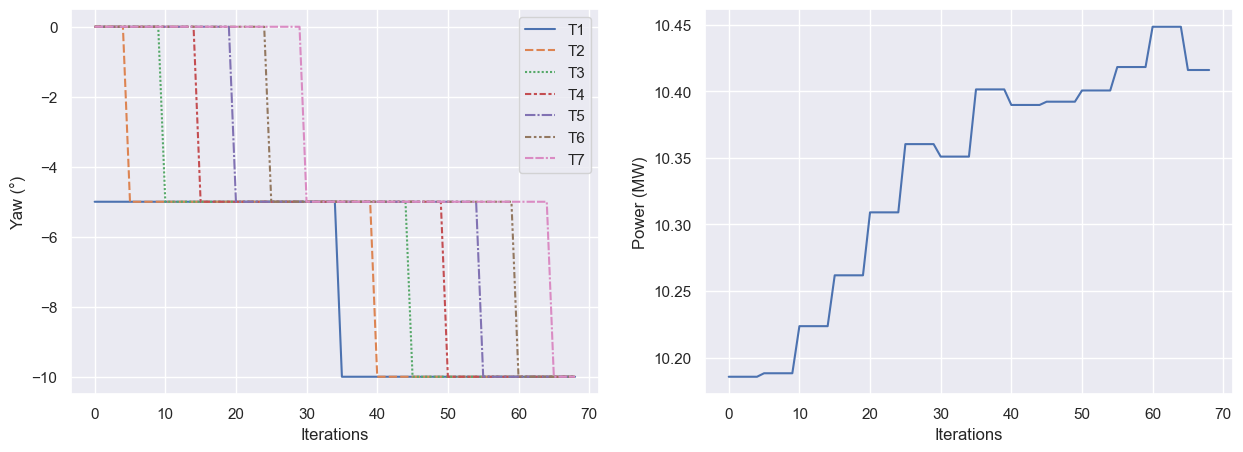

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax0 = sns.lineplot(yaws, ax=ax[0])
ax1 = sns.lineplot(powers.sum(1), ax=ax[1])
ax0.set(ylabel="Yaw (°)", xlabel="Iterations")
ax1.set(ylabel="Power (MW)", xlabel="Iterations")

### Decentralized Control

The wind farm control environment also exists in a Decentralized Control environment based on [`PettingZoo`](https://pettingzoo.farama.org/). We can access it by adding `Dec_` in front of the environment's name.

In [11]:
env = envs.make("Dec_Ablaincourt_Floris", max_num_steps=70)
env.reset()
print(env.num_turbines)
print(env.agents)

7
['turbine_1', 'turbine_2', 'turbine_3', 'turbine_4', 'turbine_5', 'turbine_6', 'turbine_7']


This is a **multi-agent environment**, where every turbine is represented by an agent. 

Let's define 7 different individual policies

In [12]:
def step_policy(i,j):
    return {"yaw": np.array([-5.0])} if i%(4*(j+1)) == 0 else {"yaw": np.zeros(1)}
def multi_agent_step_routine(env, policy):
    r = {agent: 0 for agent in env.possible_agents}
    done = {agent: False for agent in env.possible_agents}
    num_steps = {agent: 0 for agent in env.possible_agents}
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        done[agent] = done[agent] or termination or truncation
        r[agent] += reward
        if done[agent]:
            action = None
        else:
            action = policy(num_steps[agent], env.agent_name_mapping[agent])
            num_steps[agent] += 1
        env.step(action)
    return r

In [13]:
env.reset()
rewards = multi_agent_step_routine(env, step_policy)
print(f"Total rewards = {rewards}")

Total rewards = {'turbine_1': array([192.22698147]), 'turbine_2': array([192.22698147]), 'turbine_3': array([192.22698147]), 'turbine_4': array([192.22698147]), 'turbine_5': array([192.22698147]), 'turbine_6': array([192.22698147]), 'turbine_7': array([192.22698147])}


In [14]:
# Prepare plots
columns = [f"T{i+1}" for i in range(env.num_turbines)]
yaws = np.c_[[[h["yaw"] for h in env.history[agent]["observation"]]for agent in env.possible_agents]].T
powers = np.c_[[env.history[agent]["power"] for agent in env.possible_agents]].T
yaws = pd.DataFrame(yaws, columns=columns)
powers = pd.DataFrame(powers, columns=columns)

[Text(0, 0.5, 'Power (MW)'), Text(0.5, 0, 'Iterations')]

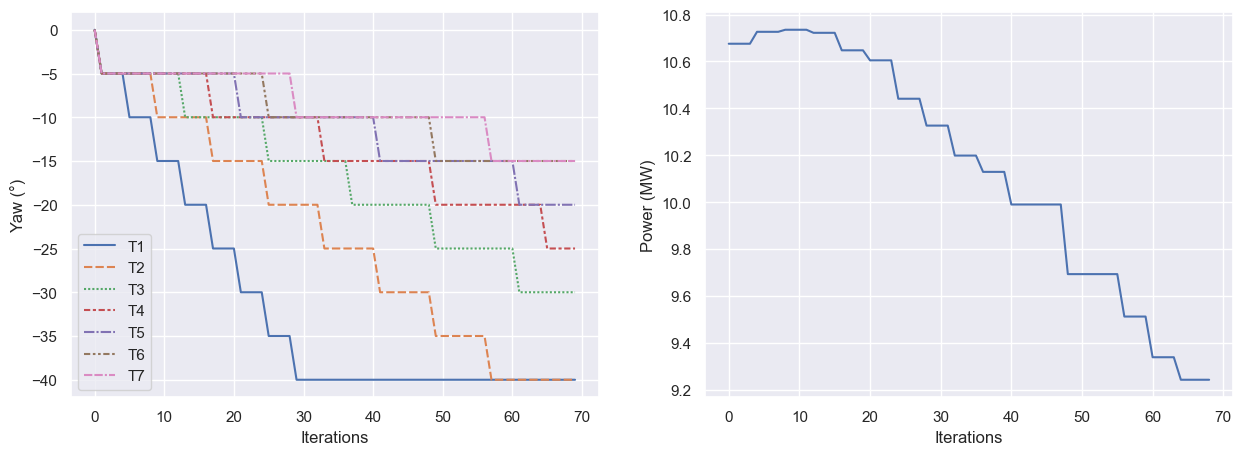

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax0 = sns.lineplot(yaws, ax=ax[0])
ax1 = sns.lineplot(powers.sum(1), ax=ax[1])
ax0.set(ylabel="Yaw (°)", xlabel="Iterations")
ax1.set(ylabel="Power (MW)", xlabel="Iterations")

### Interfacing with FastFarm

`WFCRL` implements a connexion to a simulator backend, that received actuator commands and returns simulated measures of the wind farm (of wind, yaw, pitch, load, etc.)

In [16]:
print(env.mdp.interface, env.mdp.interface.fi.configuration)

<wfcrl.interface.FlorisInterface object at 0x1390417d0> __simul__/floris/Floris__4200s__7T_1735902927.025748/case.yaml


The simulator backend for the `Ablaincourt_Floris` environment is the [FLORIS software](https://nrel.github.io/floris/). When we created the environment, `WFCRL` generated a simulation case contained in `simulators/floris/inputs/case.yaml`.

But FLORIS is a steady-state simulator, which does not simulate wind propagation dynamics. `WFCRL`  comes with support of the [`FAST.Farm` simulator](https://openfast.readthedocs.io/en/dev/source/user/fast.farm/index.html). 

In [17]:
ff_env = envs.make("Dec_Ablaincourt_Fastfarm", max_num_steps=100)

Created FAST.Farm input file: __simul__/fastfarm/FastFarm__502s__7T_1735902927.89982/FarmInputs/Case.fstf


Creating an environment with the Fasftfarm backends launches a new simulation with Fastfarm ! Fastfarm is executed in background process, and communication between our environment and Fastfarm is handled by MPI !

In [18]:
ff_env.reset()

Spawning process FAST.Farm __simul__/fastfarm/FastFarm__502s__7T_1735902927.89982/FarmInputs/Case.fstf
Interface: will receive 12 measures at every iteration


In [19]:
print(ff_env.num_turbines)
print(ff_env.agents)

7
['turbine_1', 'turbine_2', 'turbine_3', 'turbine_4', 'turbine_5', 'turbine_6', 'turbine_7']


Let's do the same routine and see the differences:

In [20]:
def ff_step_policy(i,j):
    # return {"yaw": np.zeros(1)}
    return {"yaw": np.array([-10.0])} if (i == 30 and j==0) else {"yaw": np.zeros(1)}
    # return {"yaw": np.array([5.0])} if i%(2*j) == 0 else {"yaw": np.zeros(1)}

rewards = multi_agent_step_routine(ff_env, ff_step_policy)
print(f"Total rewards = {rewards}")

Total rewards = {'turbine_1': array([240.8594937]), 'turbine_2': array([240.8594937]), 'turbine_3': array([240.8594937]), 'turbine_4': array([240.8594937]), 'turbine_5': array([240.8594937]), 'turbine_6': array([240.8594937]), 'turbine_7': array([240.8594937])}


[Text(0, 0.5, 'Power (MW)'), Text(0.5, 0, 'Iterations')]

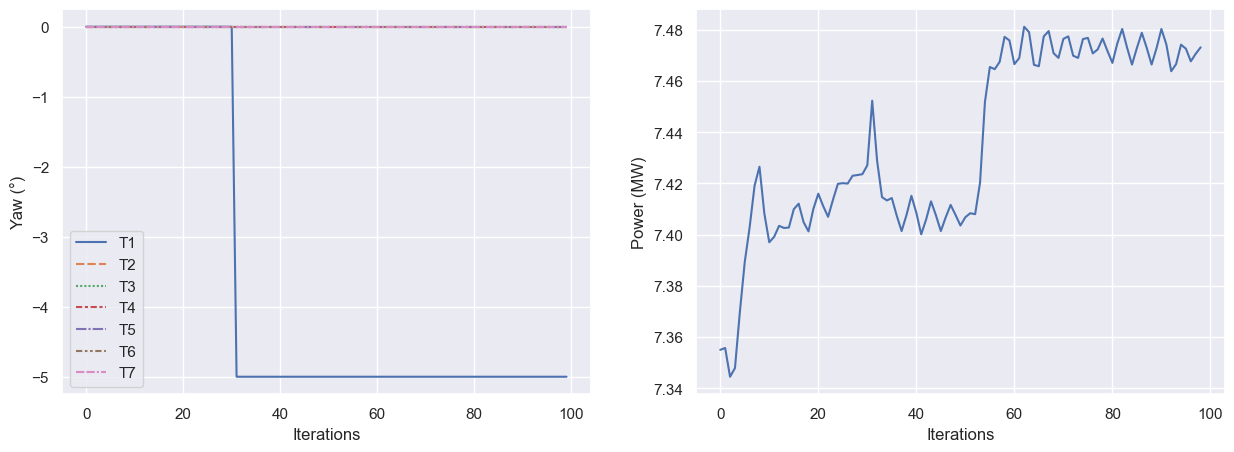

In [21]:
columns = [f"T{i+1}" for i in range(ff_env.num_turbines)]
yaws = np.c_[[[h["yaw"] for h in ff_env.history[agent]["observation"]]for agent in ff_env.possible_agents]].T
powers = np.c_[[ff_env.history[agent]["power"] for agent in ff_env.possible_agents]].T
yaws = pd.DataFrame(yaws, columns=columns)
powers = pd.DataFrame(powers, columns=columns)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax0 = sns.lineplot(yaws, ax=ax[0])
ax1 = sns.lineplot(powers.sum(1), ax=ax[1])
ax0.set(ylabel="Yaw (°)", xlabel="Iterations")
ax1.set(ylabel="Power (MW)", xlabel="Iterations")

FastFarm environments allow us to chose the actuators we will control. There can be three of them: YAW, TORQUE or PITCH. For this purpose we can define a dictionary where every key is the name of the control, with the corresponding configuration, and pass it to the `env.make` function to create the environment.

```
controls = Dict(name_of_actuator : (mininum_value, maximum_value, maximum_step_at_each_iteration))
env = envs.make(name_of_case, controls=controls) 
```

By default, yaw control is activated, and the yaw can vary between -20 and 20 with a maximal step of 5°. This is equivalent to defining 

```
controls = {"yaw": (-20, 20, 5)}
```

In [22]:
ff_env.controls

{'yaw': (-40, 40, 5)}

Let's modify the maximal yaw step and activate pitch control. This wil naturally modify the observation and action space of our environment.

In [23]:
controls = {"yaw": (-20, 20, 15), "pitch": (0, 45, 1)}
ff_env = envs.make("Dec_Ablaincourt_Fastfarm", max_num_steps=100, controls=controls)

Created FAST.Farm input file: __simul__/fastfarm/FastFarm__502s__7T_1735903166.79483/FarmInputs/Case.fstf


In [24]:
print(ff_env.controls)
print(ff_env.action_space(ff_env.possible_agents[0]))
print(ff_env.observation_space(ff_env.possible_agents[0]))

{'yaw': (-20, 20, 15), 'pitch': (0, 45, 1)}
{'pitch': Box(-1.0, 1.0, (1,), float32), 'yaw': Box(-15.0, 15.0, (1,), float32)}
{'yaw': Box(-20.0, 20.0, (1,), float32), 'pitch': Box(0.0, 45.0, (1,), float32), 'wind_speed': Box(3.0, 28.0, (1,), float32), 'wind_direction': Box(0.0, 360.0, (1,), float32), 'torque': Box(-100000.0, 100000.0, (1,), float32)}
